In [1]:
from tqdm import tqdm
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import AutoTokenizer
import torch
from peft import LoraConfig, get_peft_model
import datasets
import pandas as pd
from pathlib import Path
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

## Model

In [2]:
# Init regular Blip-2 model 
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    load_in_8bit=True,
    device_map="auto",
    torch_dtype=torch.float16,
)
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

# Use wangchanberta as tokenizer
tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2024-04-22 20:02:51.720339: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 20:02:51.758400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 20:02:51.758437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 20:02:51.759417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 20:02:51.765250: I tensorflow/core/platform/cpu_feature_guar

In [3]:
model.config.text_config.vocab_size = 25004
model.language_model.resize_token_embeddings(len(tokenizer))
processor.tokenizer = tokenizer
model.config.eos_token_id = 6

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

# Parameter effective fine-tuning
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,685,236,736 || trainable%: 0.1423


## Dataset

In [5]:
images_path = list(Path("/root/Datasets/Images").glob("*.jpg"))
labels = pd.read_csv("/root/Datasets/preprocess.csv")
images = [Image.open(str(images_path[0].parent / path)) for path in labels['image']]

In [6]:
dataset = datasets.Dataset.from_dict({"image": images, "text": labels['caption']})
dataset = dataset.train_test_split(test_size=0.1, seed=42)

In [8]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [9]:
train_dataset = ImageCaptioningDataset(dataset['train'], processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, collate_fn=collate_fn)

# test_dataset = ImageCaptioningDataset(dataset['test'], processor)
# test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=32, collate_fn=collate_fn)

## Training

In [12]:
# This is just for feeding test
# for batch in tqdm(train_dataloader):
#     input_ids = batch.pop("input_ids").to(device)
#     pixel_values = batch.pop("pixel_values").to(device, torch.float16)
    
#     outputs = model(
#         input_ids=input_ids,
#         pixel_values=pixel_values,
#         labels=input_ids
#     )
    
#     break

  0%|          | 0/1138 [00:03<?, ?it/s]


In [10]:
import torch
import os
from tqdm import tqdm

experiment_name = "model_reg_blip2-3"
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2)

for epoch in range(10):
    print("Epoch:", epoch)
    model.train()
    
    training_loss = 0
    validate_loss = 0
    
    idx = 0
    
    for batch in tqdm(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)
        
        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            labels=input_ids
        )

        loss = outputs.loss
        training_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    print("Training loss", training_loss / len(train_dataloader))
    print("-" * 60)
    
    save_dir = os.path.join(experiment_name, str(epoch))
    os.makedirs(save_dir, exist_ok=True)
    model.save_pretrained(save_dir)

Epoch: 0


100%|██████████| 1138/1138 [19:20<00:00,  1.02s/it]


Training loss 3.438836980997364
------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:589: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e371238f-59b2-4786-aa13-c1cfb1746bee)') - silently ignoring the lookup for the file config.json in Salesforce/blip2-opt-2.7b.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:192: UserWarning: Could not find a config file in Salesforce/blip2-opt-2.7b - will assume that the vocabulary was not modified.
  warnings.warn(


Epoch: 1


 13%|█▎        | 143/1138 [02:25<16:49,  1.01s/it]


KeyboardInterrupt: 

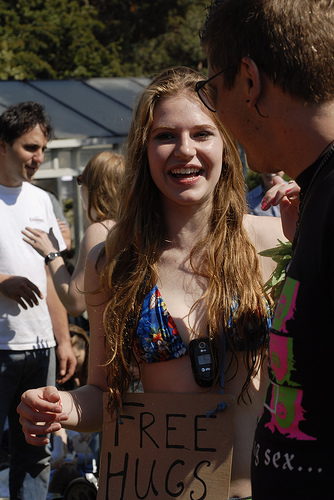

In [17]:
im = dataset['test'].select([500])['image'][0]
im

In [18]:
pixel_values = processor(im, return_tensors="pt").to(device, torch.float16).pixel_values
model.eval()

outputs = model.generate(pixel_values=pixel_values)

In [19]:
print(outputs)
generated_caption = processor.batch_decode(outputs, skip_special_tokens=True)[0]
print(generated_caption)

tensor([[   2,   10,  551,   20, 5806,   13, 5806,    6,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1]], device='cuda:0')
ผู้หญิงในหมวกและหมวก


## Save and load model

### Save

In [21]:
model.save_pretrained("adapter2")

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:589: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 5087756c-8854-4e1f-a925-0eed661e4ccc)') - silently ignoring the lookup for the file config.json in Salesforce/blip2-opt-2.7b.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:192: UserWarning: Could not find a config file in Salesforce/blip2-opt-2.7b - will assume that the vocabulary was not modified.
  warnings.warn(


### Loading model

In [20]:
load = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    load_in_8bit=True,
    device_map="auto",
    torch_dtype=torch.float16,
)

load.config.text_config.vocab_size = 25004
load.language_model.resize_token_embeddings(len(tokenizer))
processor.tokenizer = tokenizer
load.config.eos_token_id = 6

# Adapter path
load.load_adapter("adapter2")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]